## CARDIOVASCULAR DISEASE KNN CLASSIFICATION MODEL 

**INTRODUCTION**

According to the World Health Organization, cardiovascular disease is the leading global cause of death. Over 17.9 million patients die from the disease each year (Centers for Disease Control and Prevention, 2022). Cardiovascular disease is characterized by high blood pressure, cholesterol and chest pain leading to heart failure, arrhythmia and heart attack symptoms (World Health Organization, 2023).

Due to growing prevalence of machine learning algorithms in health care, our goal is to create and train a model using the KNN classification algorithm that will predict whether individuals are likely to have cardiovascular disease based on various clinical attributes. 

**Research question**: Which individuals are likely to have cardiovascular disease according to various clinical attributes?

The "hungarian heart disease" dataset obtained from the machine learning repository contains 294 observations representing the patients of the study. It has 14 columns with various clinical attributes associated with cardiovascular disease as well as the patient's diagnosis (UCI Machine Learning Repository, 2023).

In [1]:
library(tidyverse)
library(tidymodels)
set.seed(123)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

**PRELIMINARY DATA ANALYSIS**

We begin by loading the dataset into R and adding column names. The dataset is already in tidy format so we can mutate each variable to the correct data type.   

In [2]:
heart_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data", col_names = FALSE)

heart_data_renamed <- rename(heart_data, 
                        age = X1, 
                        sex = X2, 
                        chest_pain_type= X3, 
                        resting_blood_pressure = X4, 
                        serum_cholestoral = X5, 
                        fasting_blood_sugar = X6, 
                        resting_electrocardiographic_results = X7, 
                        max_heart_rate = X8, 
                        exercise_induced_angina = X9, 
                        oldpeak = X10, 
                        slope = X11, 
                        number_vessels = X12, 
                        thal = X13, 
                        diagnosis = X14)            

heart_data_renamed <- heart_data_renamed |>
    mutate(across(c(diagnosis, sex, chest_pain_type, fasting_blood_sugar, resting_electrocardiographic_results,exercise_induced_angina), as.factor))|>
    mutate(across(c(resting_blood_pressure), as.numeric))
head(heart_data_renamed)


Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


age,sex,chest_pain_type,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,max_heart_rate,exercise_induced_angina,oldpeak,slope,number_vessels,thal,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<chr>,<fct>,<fct>,<chr>,<fct>,<dbl>,<chr>,<chr>,<chr>,<fct>
28,1,2,130,132,0,2,185,0,0,?,?,?,0
29,1,2,120,243,0,0,160,0,0,?,?,?,0
29,1,2,140,?,0,0,170,0,0,?,?,?,0
30,0,1,170,237,0,1,170,0,0,?,?,6,0
31,0,2,100,219,0,1,150,0,0,?,?,?,0
32,0,2,105,198,0,0,165,0,0,?,?,?,0


**Table 1:** Heart data after adding column names 

We create a new dataframe with the following variables: age, resting blood pressure, blood cholestoral, maximum heart rate, and diagnosis. These are the variables that we will explore as potential variables on which to train the model because they are numeric and have minimal missing values. We can then filter out any remaining observations with missing values. 

In [3]:
 tidy_heart_data <- heart_data_renamed  |>
    select(age, resting_blood_pressure, serum_cholestoral, max_heart_rate, diagnosis) |>
    filter(age != "?", resting_blood_pressure != "?", serum_cholestoral != "?", max_heart_rate != "?", diagnosis != "?")
head(tidy_heart_data)

age,resting_blood_pressure,serum_cholestoral,max_heart_rate,diagnosis
<dbl>,<dbl>,<chr>,<chr>,<fct>
28,130,132,185,0
29,120,243,160,0
30,170,237,170,0
31,100,219,150,0
32,105,198,165,0
32,110,225,184,0


**Table 2:** Tidy data with missing values removed

Using our tidy dataframe, we divide our dataset into a training and testing set using set.seed for a random yet reproducible split. We choose a 75:25 split because we want a large training set with enough observations to create an accurate model but also enough observations in the testing set to get an accurate estimate of its prediction accuracy. The use of the strata argument is to stratify the data by diagnosis so the classes are evenly distributed between training and testing data. 

In [4]:
split_heart_data <- initial_split(tidy_heart_data, prop = 0.75, strata = diagnosis)
training_heart_data <- training(split_heart_data)
testing_heart_data <- testing(split_heart_data)
head(training_heart_data) 
head(testing_heart_data)

age,resting_blood_pressure,serum_cholestoral,max_heart_rate,diagnosis
<dbl>,<dbl>,<chr>,<chr>,<fct>
31,100,219,150,0
32,105,198,165,0
32,110,225,184,0
32,125,254,155,0
33,120,298,185,0
34,130,161,190,0


age,resting_blood_pressure,serum_cholestoral,max_heart_rate,diagnosis
<dbl>,<dbl>,<chr>,<chr>,<fct>
28,130,132,185,0
29,120,243,160,0
30,170,237,170,0
34,150,214,168,0
35,150,264,168,0
36,130,209,178,0


**Table 3:** Training and testing data with all potential predictor variables

As diagnosis is the response variable for this model, we use the training data to create a summary table showing the number and percentage of observations that do and do not have a heart disease diagnosis. 

In [5]:
summary_heart_data <- training_heart_data|>
    group_by(diagnosis)|>
    summarize(Count=n())|>
    mutate(Percent = Count/201)
summary_heart_data

diagnosis,Count,Percent
<fct>,<int>,<dbl>
0,126,0.6268657
1,75,0.3731343


**Table 4:** Count and percentage with (1) and without (0) heart disease

We can create a summary table of means for the potential predictor variables to be used in the model. 

In [6]:
summary_heart_data_2 <- training_heart_data |>
    summarize(mean_age = mean(age, na.rm = TRUE), 
                mean_blood_pressure = mean(as.numeric(resting_blood_pressure), na.rm = TRUE),
                mean_cholestoral = mean(as.numeric(serum_cholestoral), na.rm = TRUE),
                mean_max_heart_rate = mean(as.numeric(max_heart_rate), na.rm = TRUE))
summary_heart_data_2

mean_age,mean_blood_pressure,mean_cholestoral,mean_max_heart_rate
<dbl>,<dbl>,<dbl>,<dbl>
48.22388,132.2786,253.3682,140.01


**Table 5:** Mean values for each potential predictor variable

This table shows that the average patient was middle-aged and had elevated blood pressures (healthy range < 120mm/Hg) and blood cholesterol (healthy levels < 200mg/dL) (UptoDate, 2023). The average maximum heart rates appear to be relatively normal according to the average adult heart rate (WebMD, 2021).

We now plot scatterplots using the training data to compare the potential predictor variables to each other and examine their relationship to diagnosis. The points are coloured by diagnosis and made transparent so overlapping points are more easily distinguished. 

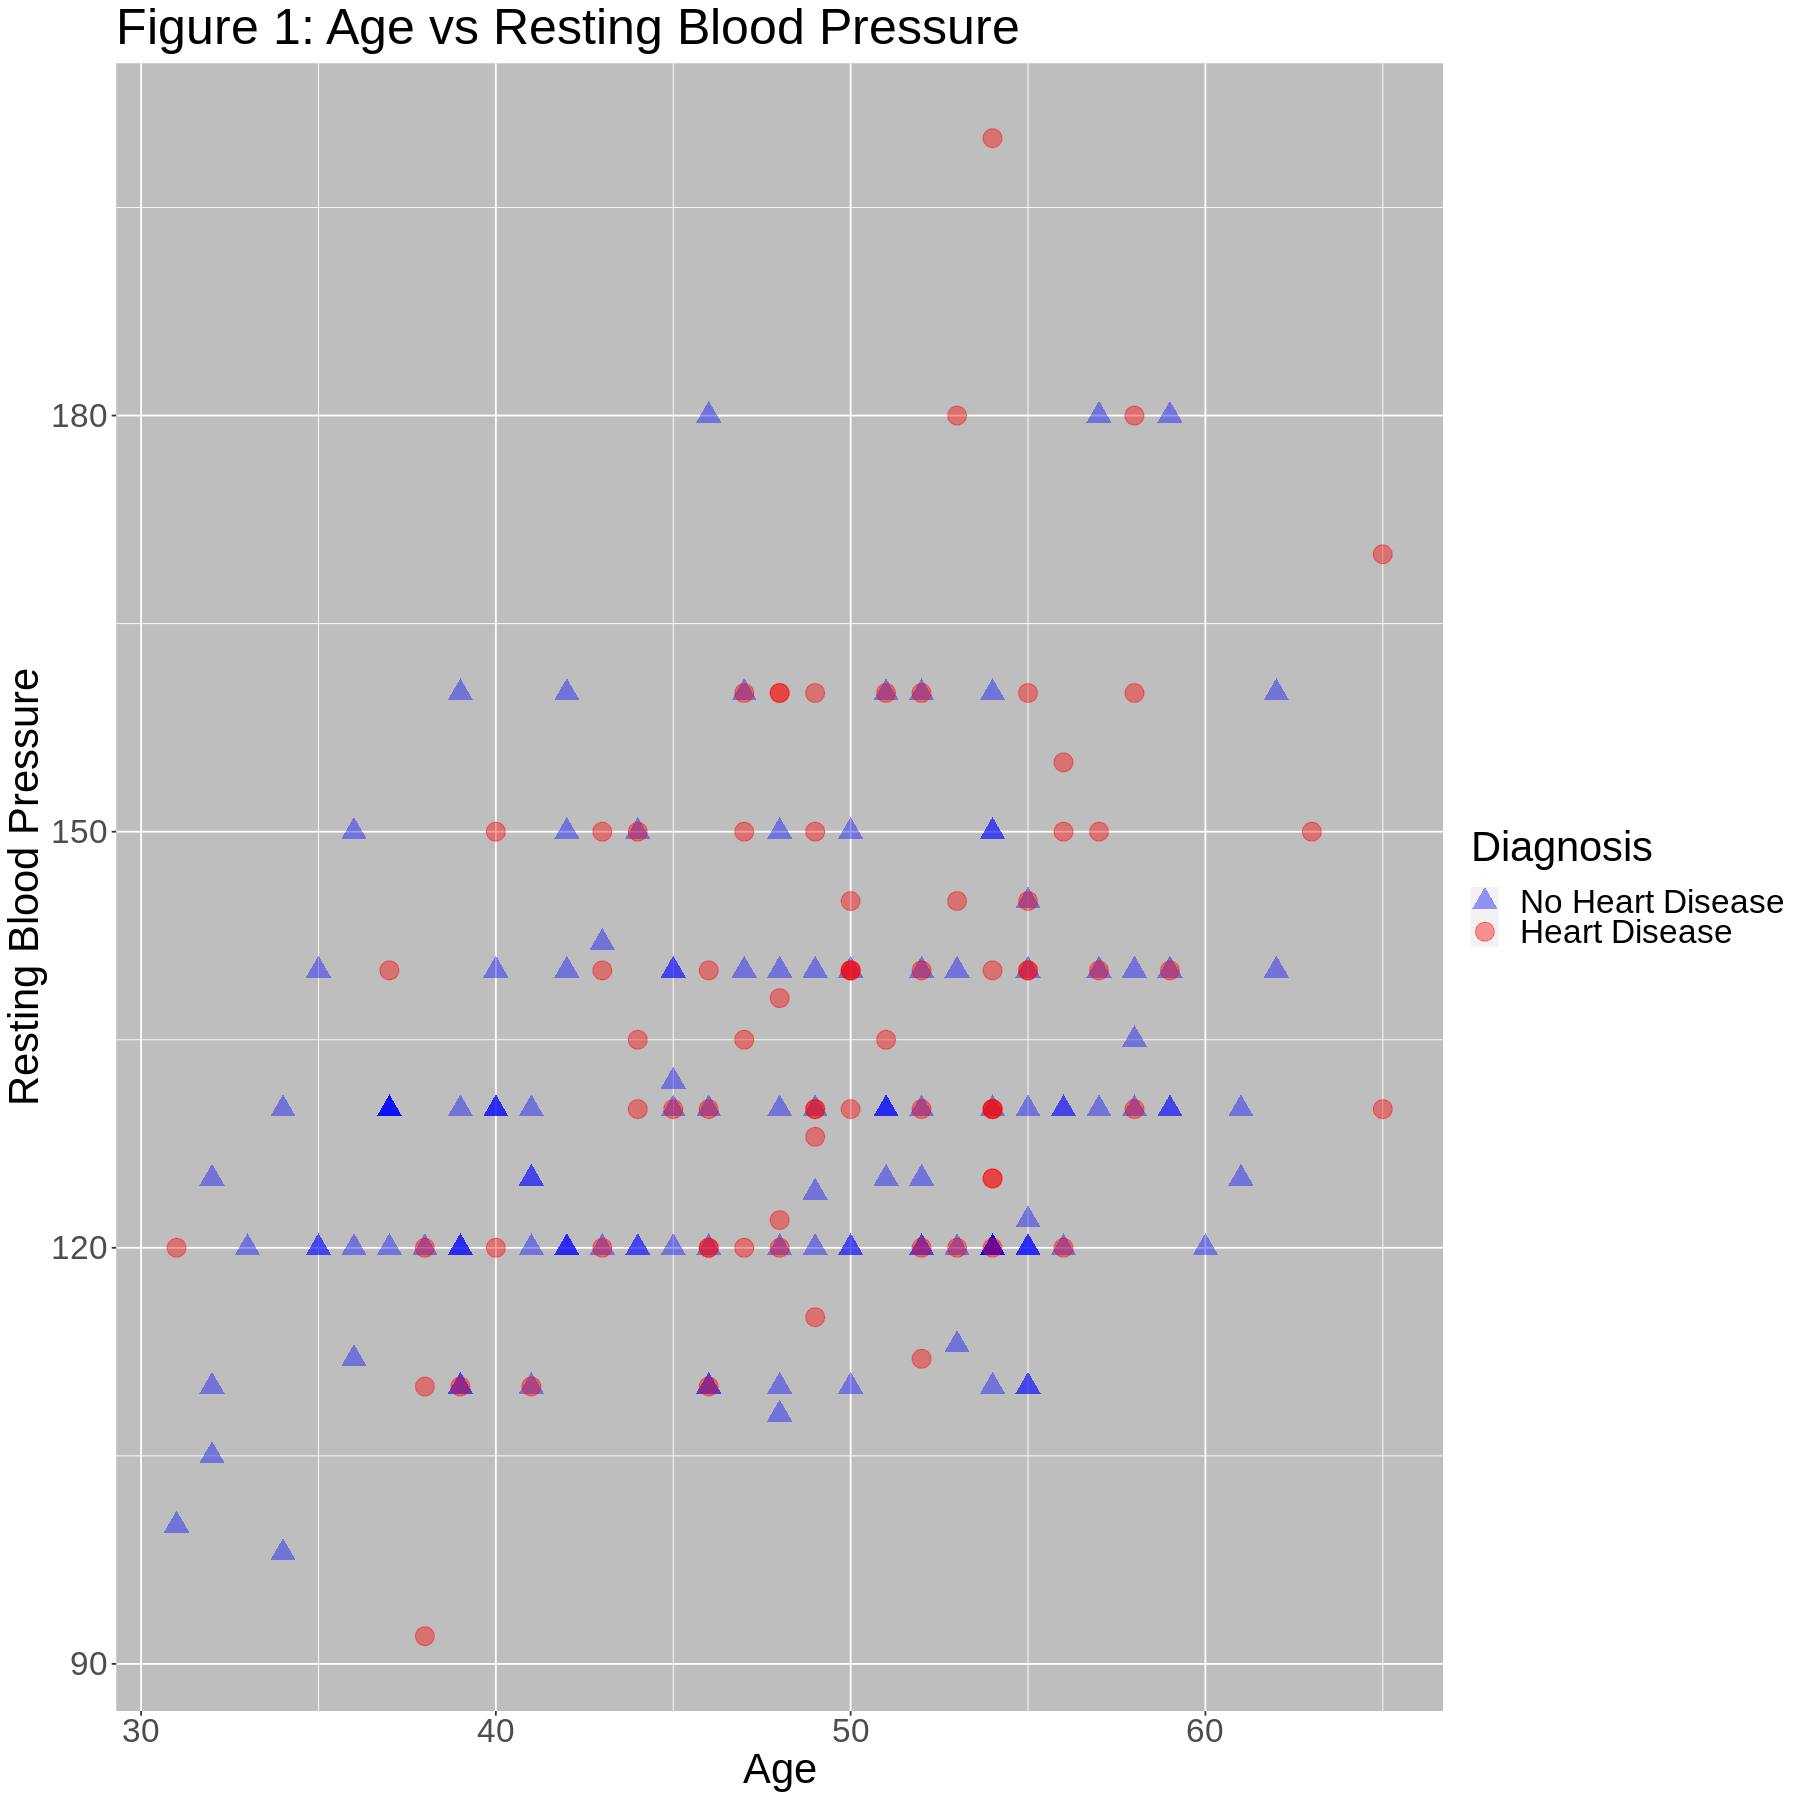

In [7]:
options(repr.plot.width = 15, repr.plot.height = 15)
age_vs_blood_pressure_plot <- training_heart_data |>
    ggplot(aes(x = age, y = as.numeric(resting_blood_pressure), color = as.factor(diagnosis), shape = as.factor(diagnosis))) +
    geom_point(alpha = 0.4, size = 5) +
    labs(x = "Age", y = "Resting Blood Pressure", color = "Diagnosis", shape = "Diagnosis") +
    theme(text = element_text(size = 25), panel.background = element_rect(fill = "grey")) +
    scale_color_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("blue", "red")) +
    scale_shape_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("triangle", "circle")) +
    ggtitle("Figure 1: Age vs Resting Blood Pressure")
age_vs_blood_pressure_plot

Figure 1 shows there appears to be no relationship between age and resting blood pressure in relation to the diagnosis of the observations. While there is a slight clustering of points with lower age and lower resting blood pressure that have no heart disease, the diagnosed and undiagnosed data points are otherwise evenly distributed. 

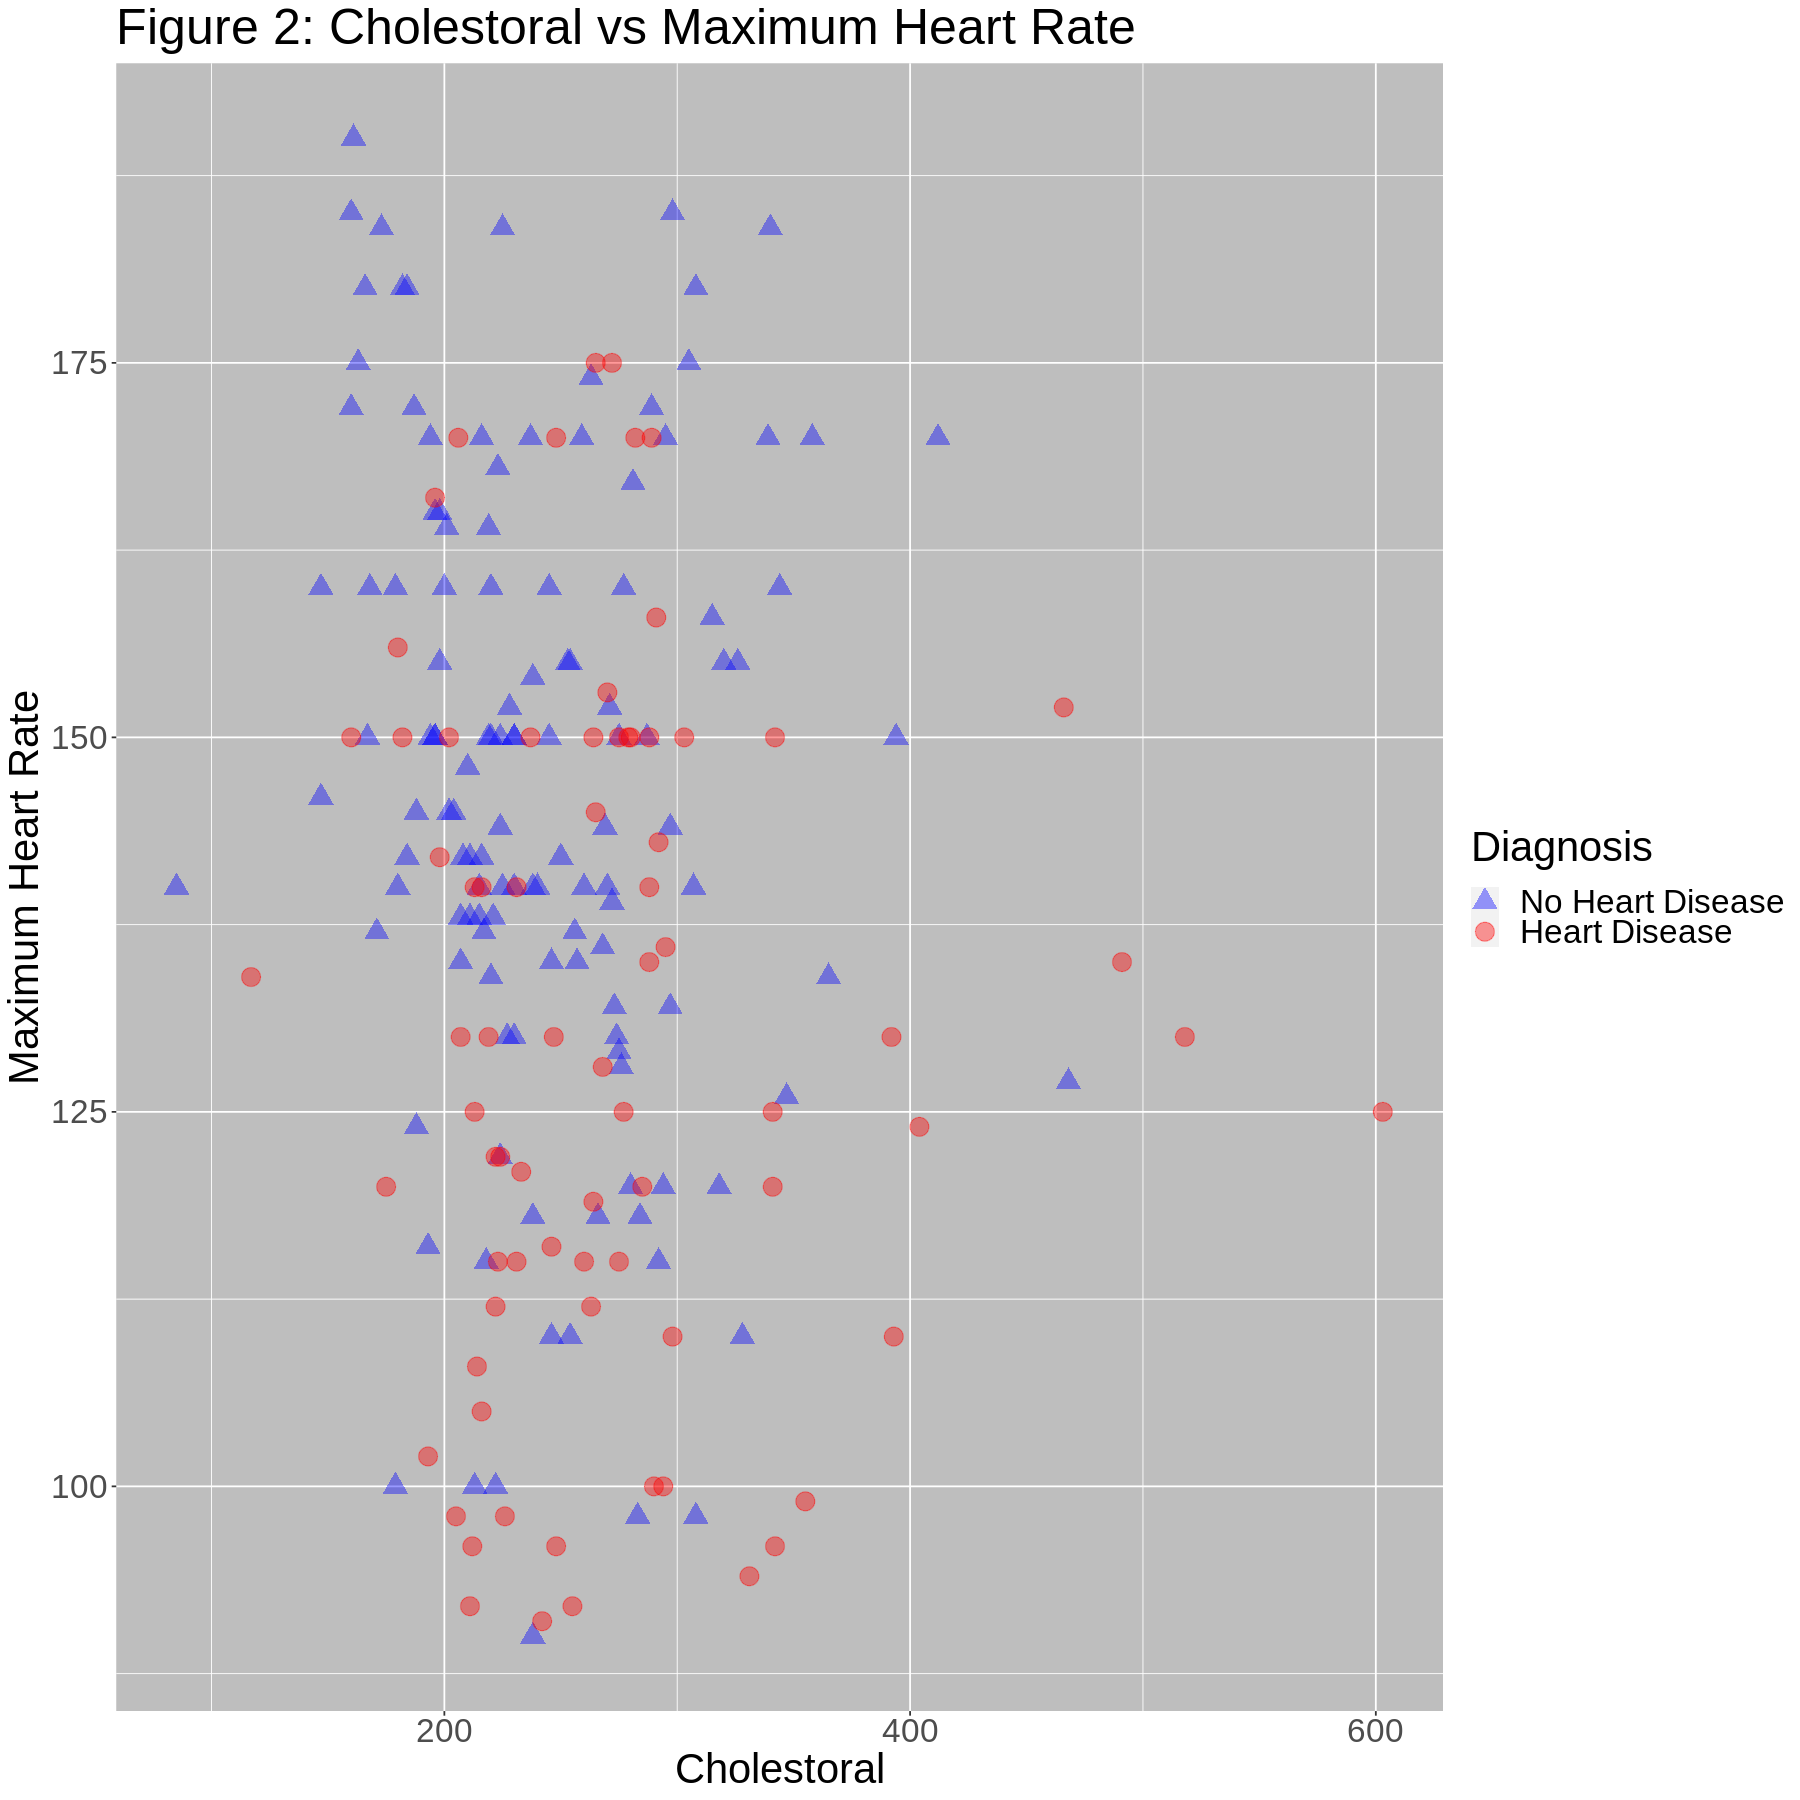

In [8]:
options(repr.plot.width = 15, repr.plot.height = 15)
age_vs_max_heart_rate_plot <- training_heart_data |>
    ggplot(aes(x = as.numeric(serum_cholestoral), y = as.numeric(max_heart_rate), color = as.factor(diagnosis), shape = as.factor(diagnosis))) +
    geom_point(alpha = 0.4, size = 5) +
    labs(x = "Cholestoral", y = "Maximum Heart Rate", color = "Diagnosis", shape = "Diagnosis") +
    theme(text = element_text(size = 25), panel.background = element_rect(fill = "grey")) +
    scale_color_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("blue", "red")) +
    scale_shape_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("triangle", "circle")) +
    ggtitle("Figure 2: Cholestoral vs Maximum Heart Rate")
age_vs_max_heart_rate_plot 


Figure 2 shows clustering of data points with higher maximum heart rate and low cholesterol that do not have heart disease. In contrast, there appears to be more data points with lower maximum heart rate and higher cholesterol that do have heart disease. This shows a general relationship that lower maximum heart rate and higher cholestoral results in patients being more likely to have heart disease. 

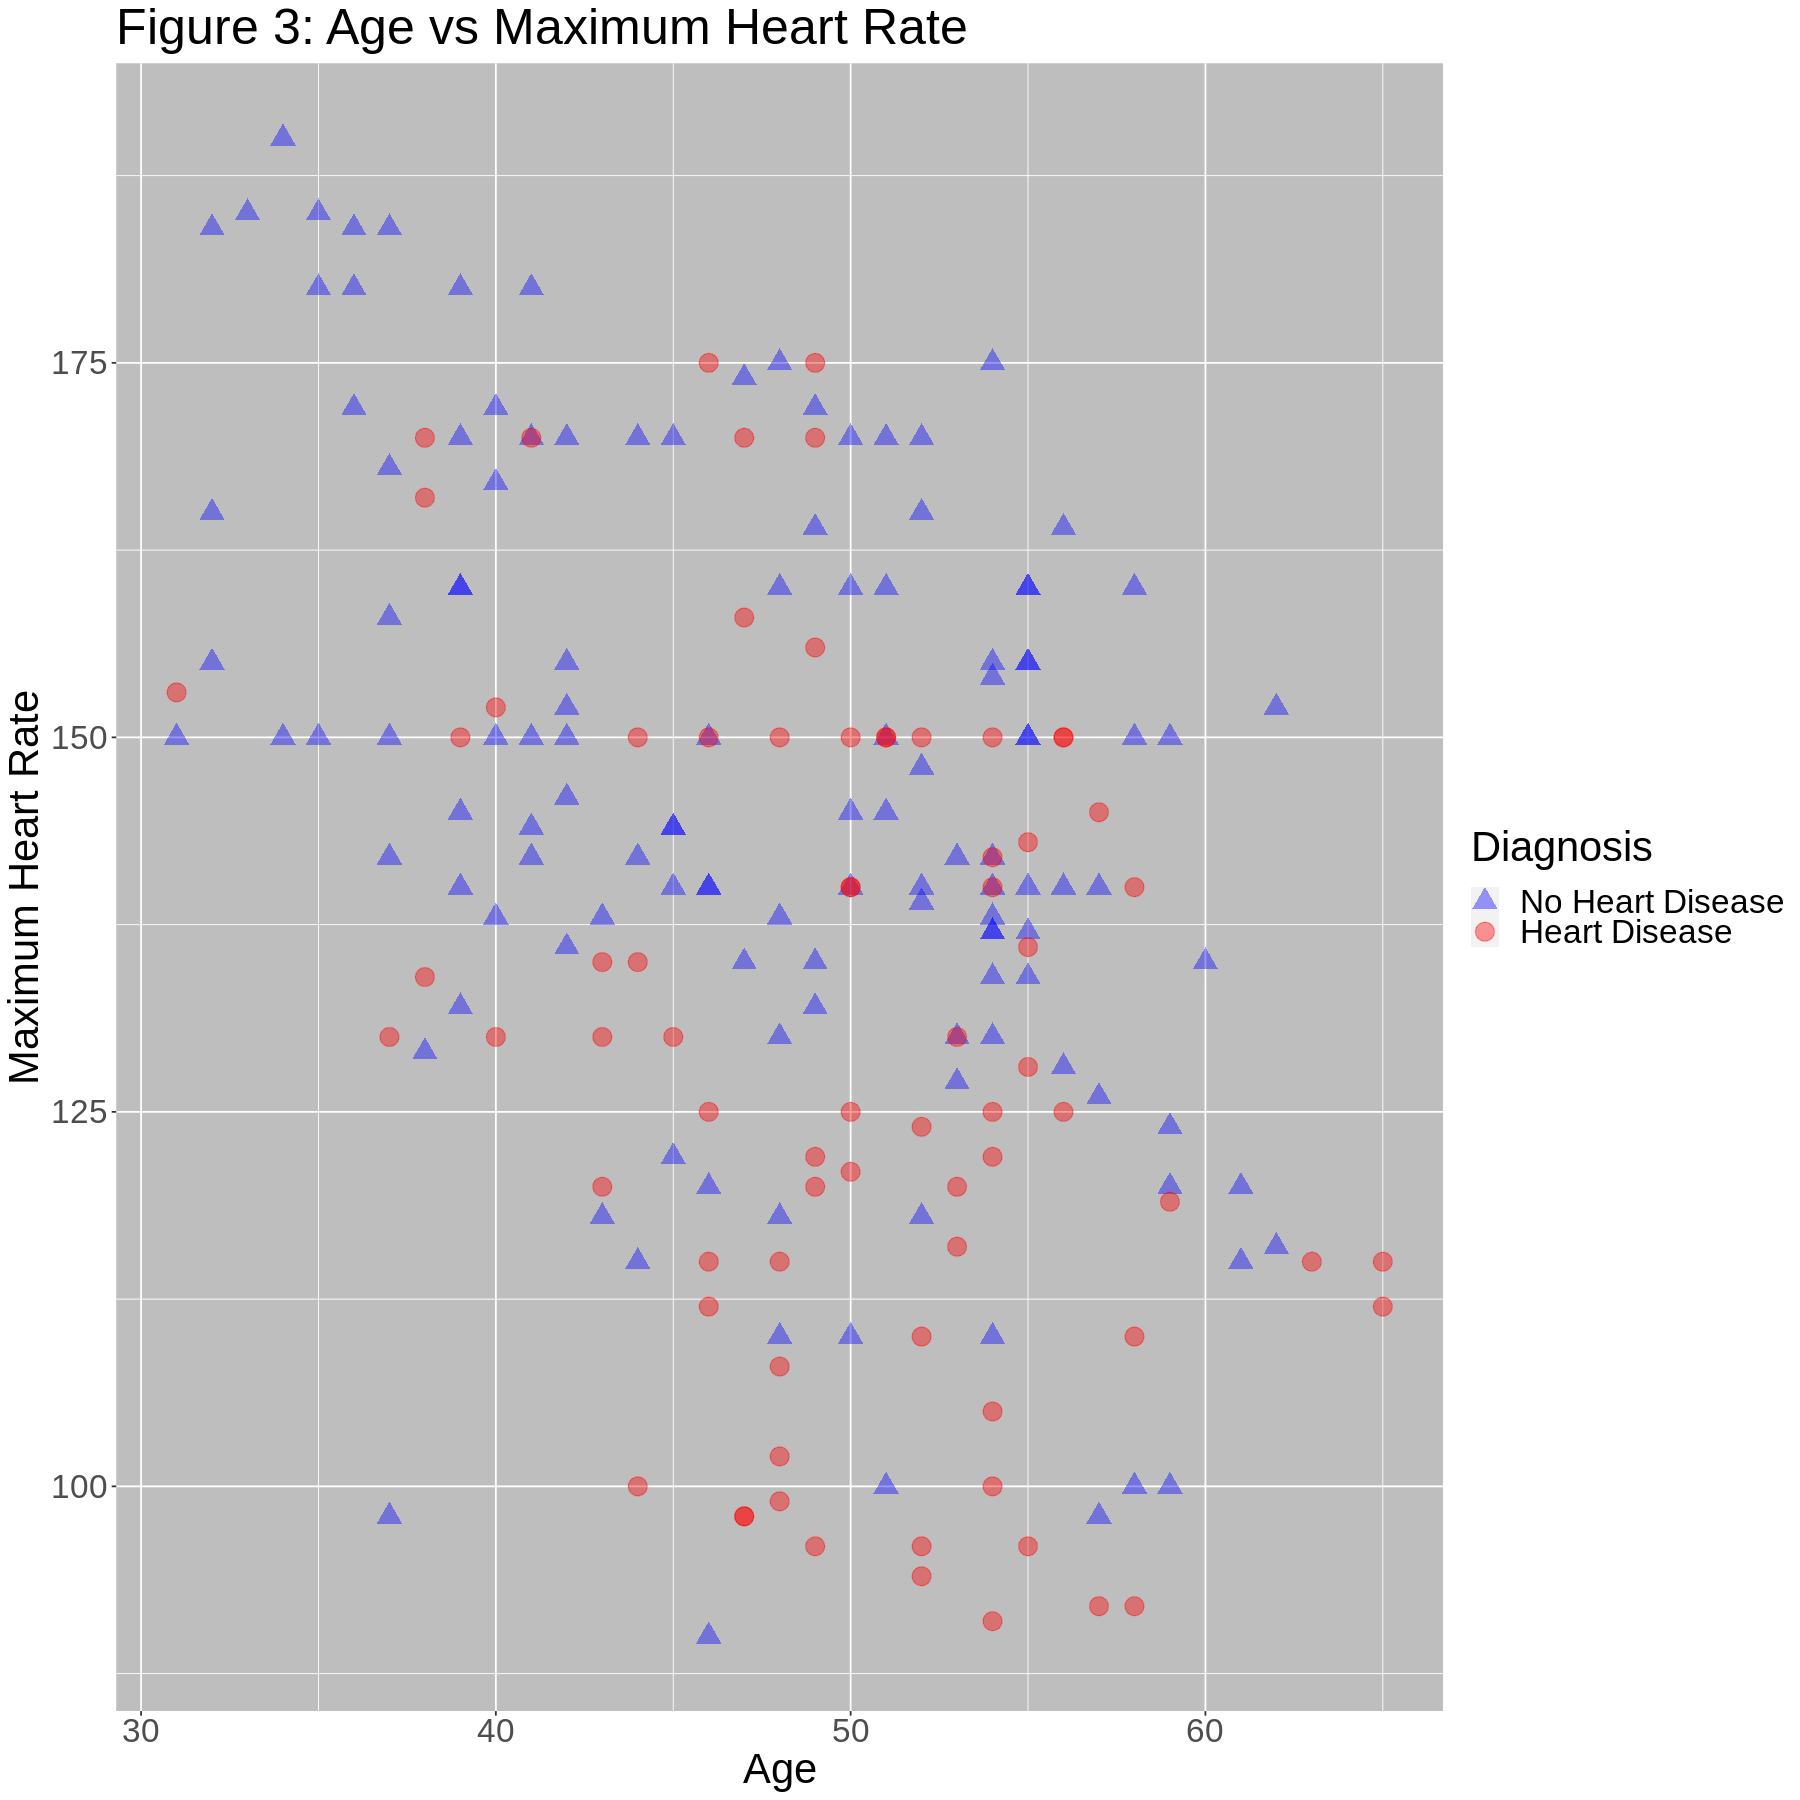

In [9]:
options(repr.plot.width = 15, repr.plot.height = 15)
max_heart_rate_vs_cholestoral_plot <- training_heart_data |>
    ggplot(aes(x = age, y = as.numeric(max_heart_rate), color = as.factor(diagnosis), shape = as.factor(diagnosis))) +
    geom_point(alpha = 0.4, size = 5) +
    labs(x = "Age", y = "Maximum Heart Rate", color = "Diagnosis", shape = "Diagnosis") +
    theme(text = element_text(size = 25), panel.background = element_rect(fill = "grey")) +
    scale_color_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("blue", "red")) +
    scale_shape_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("triangle", "circle")) +
    ggtitle("Figure 3: Age vs Maximum Heart Rate")
max_heart_rate_vs_cholestoral_plot

Figure 3 shows patients with higher maximum heart rate are diagnosed less often. Older patients are diagnosed more often. Maximum heart rate and age appear to have a weak negative correlation.

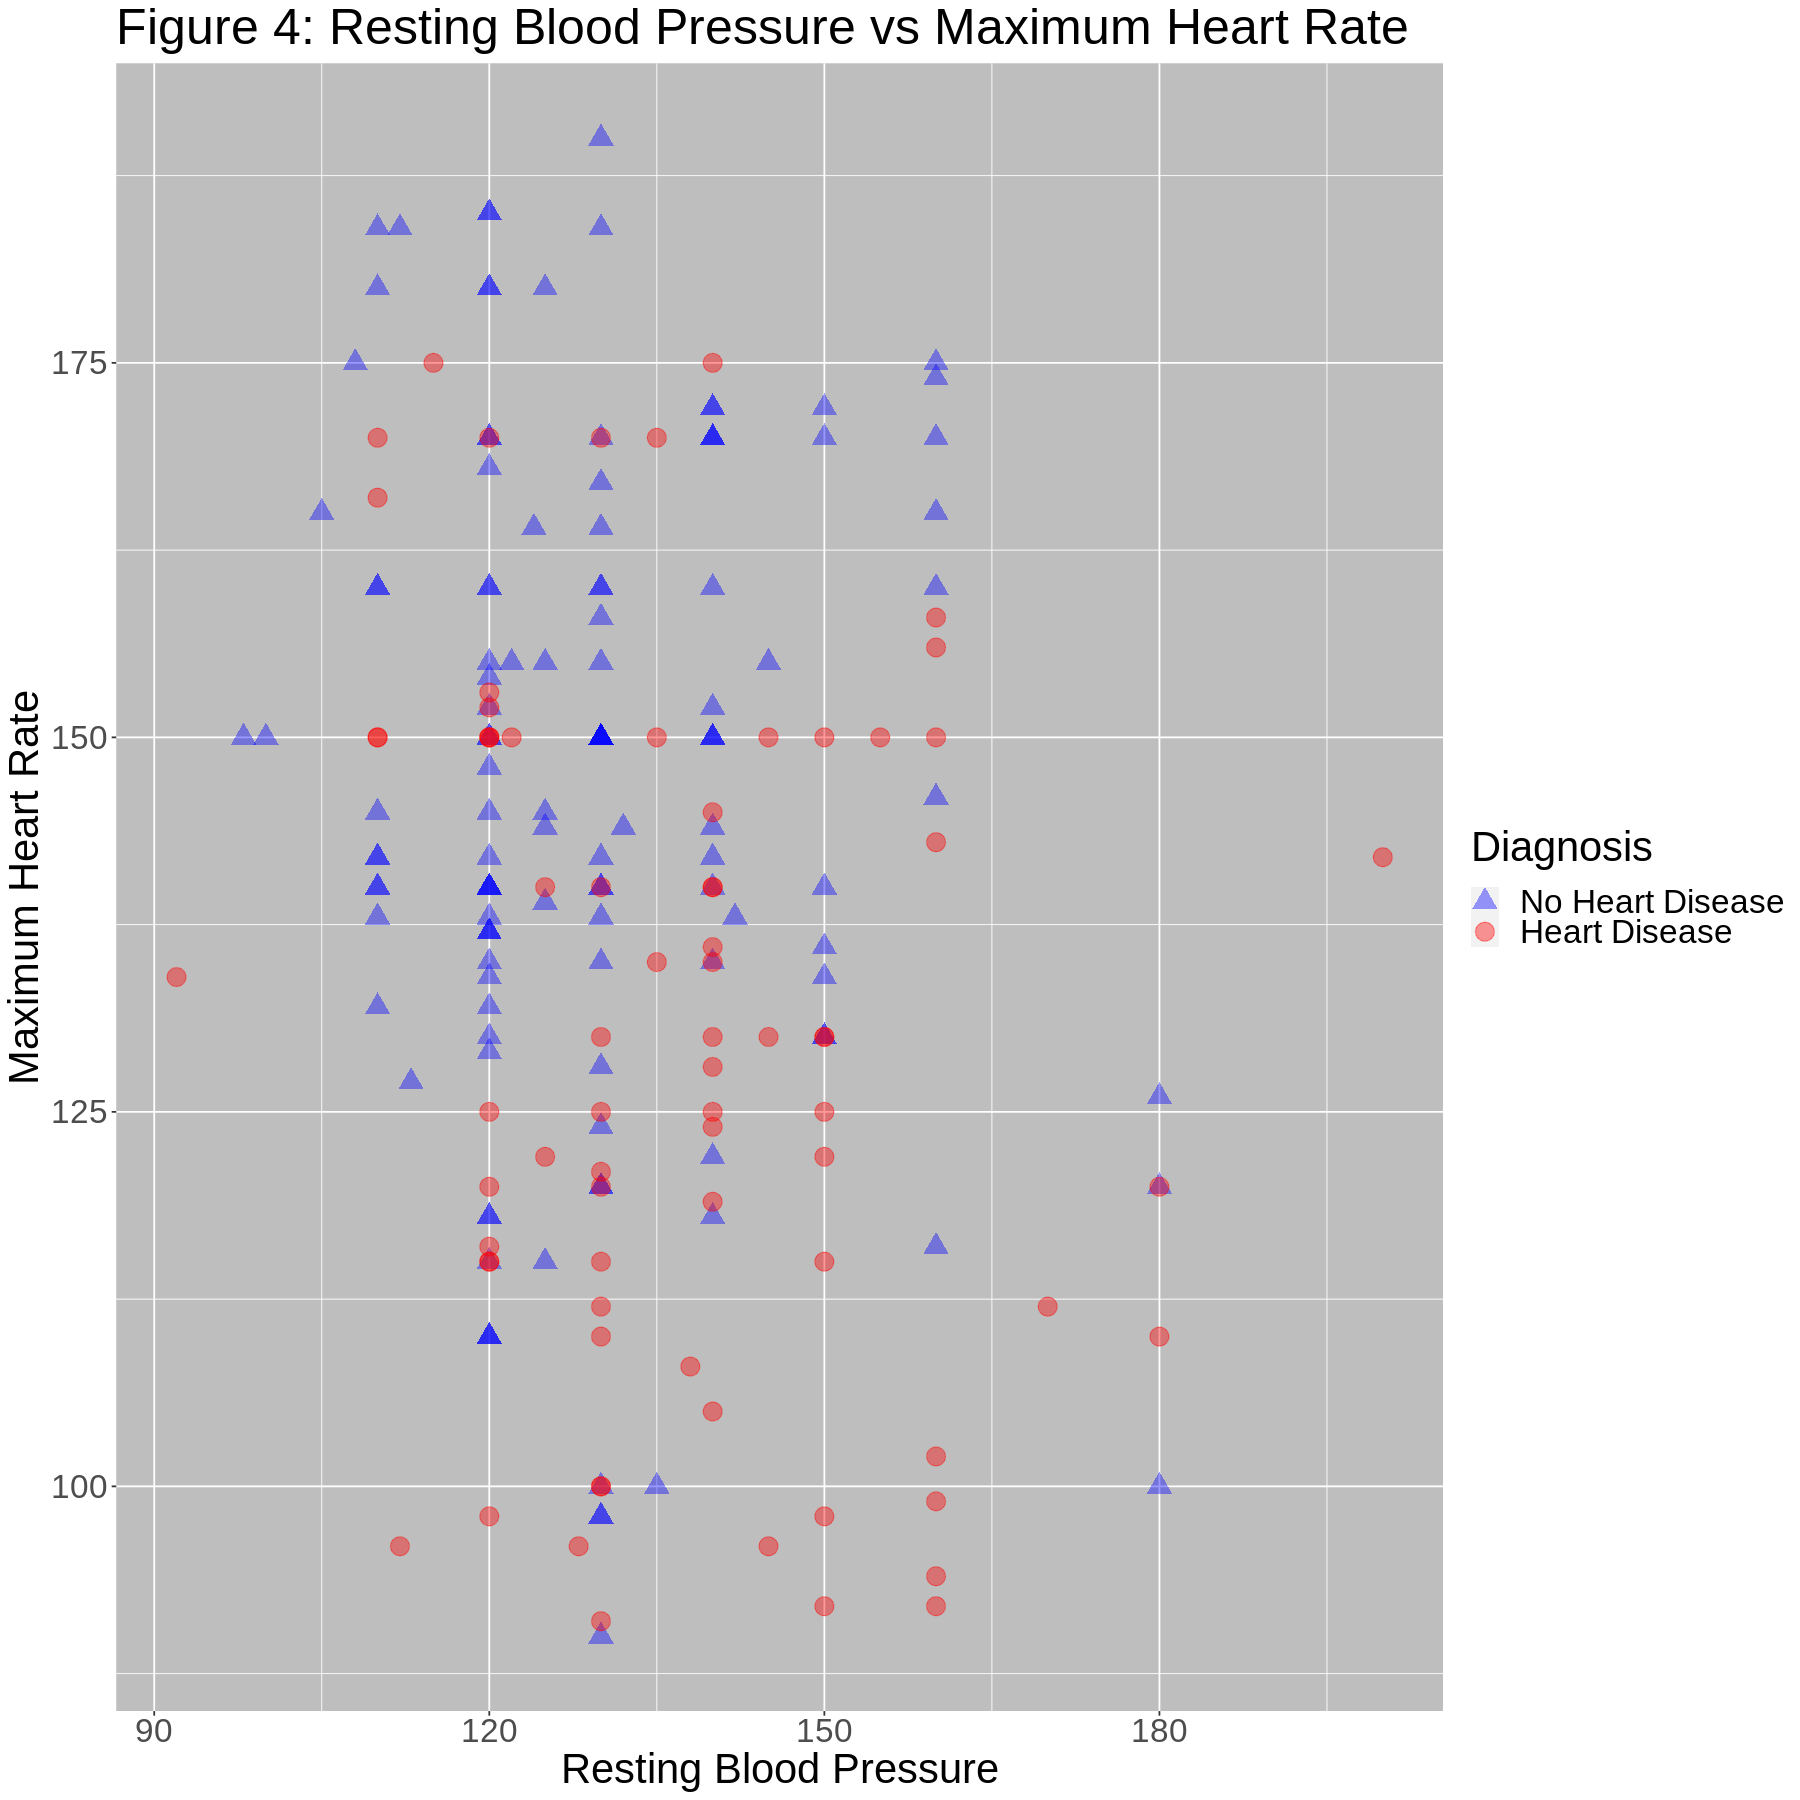

In [10]:
options(repr.plot.width = 15, repr.plot.height = 15)
resting_blood_pressure_vs_max_heart_rate_plot <- training_heart_data |>
    ggplot(aes(x = as.numeric(resting_blood_pressure), y = as.numeric(max_heart_rate), color = as.factor(diagnosis), shape = as.factor(diagnosis))) +
    geom_point(alpha = 0.4, size = 5) +
    labs(x = "Resting Blood Pressure", y = "Maximum Heart Rate", color = "Diagnosis", shape = "Diagnosis") +
    theme(text = element_text(size = 25), panel.background = element_rect(fill = "grey")) +
    scale_color_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("blue", "red")) +
    scale_shape_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("triangle", "circle")) +
    ggtitle("Figure 4: Resting Blood Pressure vs Maximum Heart Rate")
resting_blood_pressure_vs_max_heart_rate_plot

Figure 4 shows there appears to be no relationship between resting blood pressure and maximum heart rate as the points are fairly evenly distributed according to the diagnosis. 

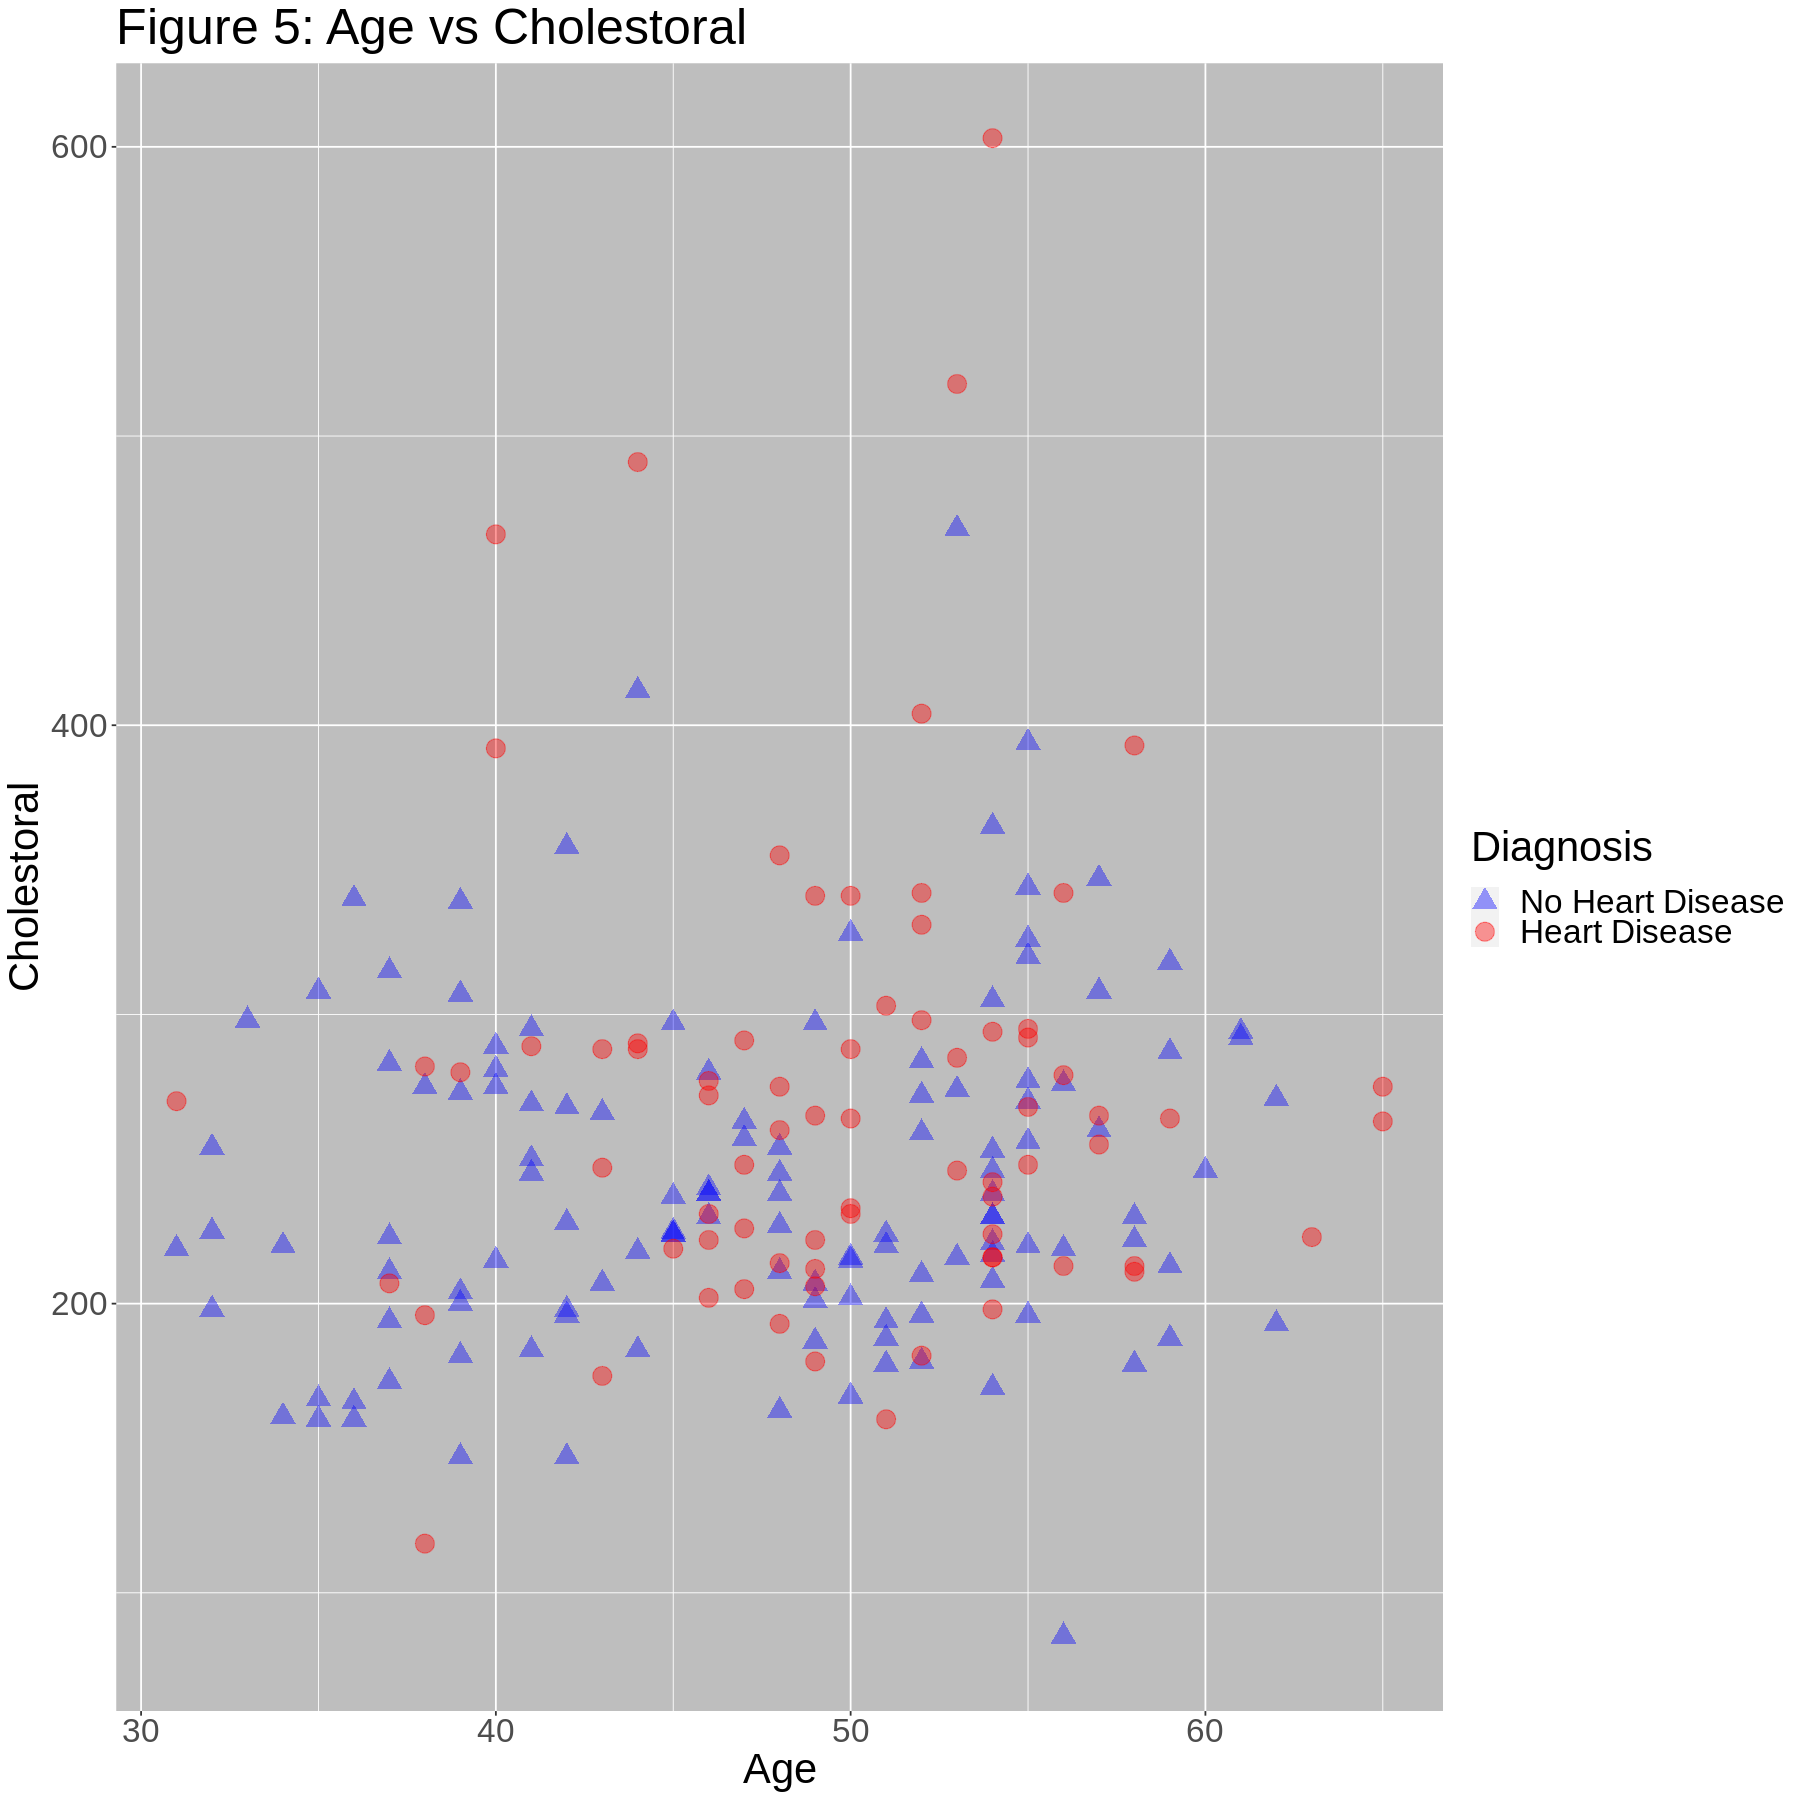

In [11]:
options(repr.plot.width = 15, repr.plot.height = 15)
age_vs_cholestoral_plot <- training_heart_data |>
    ggplot(aes(x = age, y = as.numeric(serum_cholestoral), color = as.factor(diagnosis), shape = as.factor(diagnosis))) +
    geom_point(alpha = 0.4, size = 5) +
    labs(x = "Age", y = "Cholestoral", color = "Diagnosis", shape = "Diagnosis") +
    theme(text = element_text(size = 25), panel.background = element_rect(fill = "grey")) +
    scale_color_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("blue", "red")) +
    scale_shape_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("triangle", "circle")) +
    ggtitle("Figure 5: Age vs Cholestoral")
age_vs_cholestoral_plot

Figure 5 shows older patients are diagnosed more often. Patients with higher cholesterol are also diagnosed more often. There is no relationship between cholesterol and age in relation to the diagnosis. 

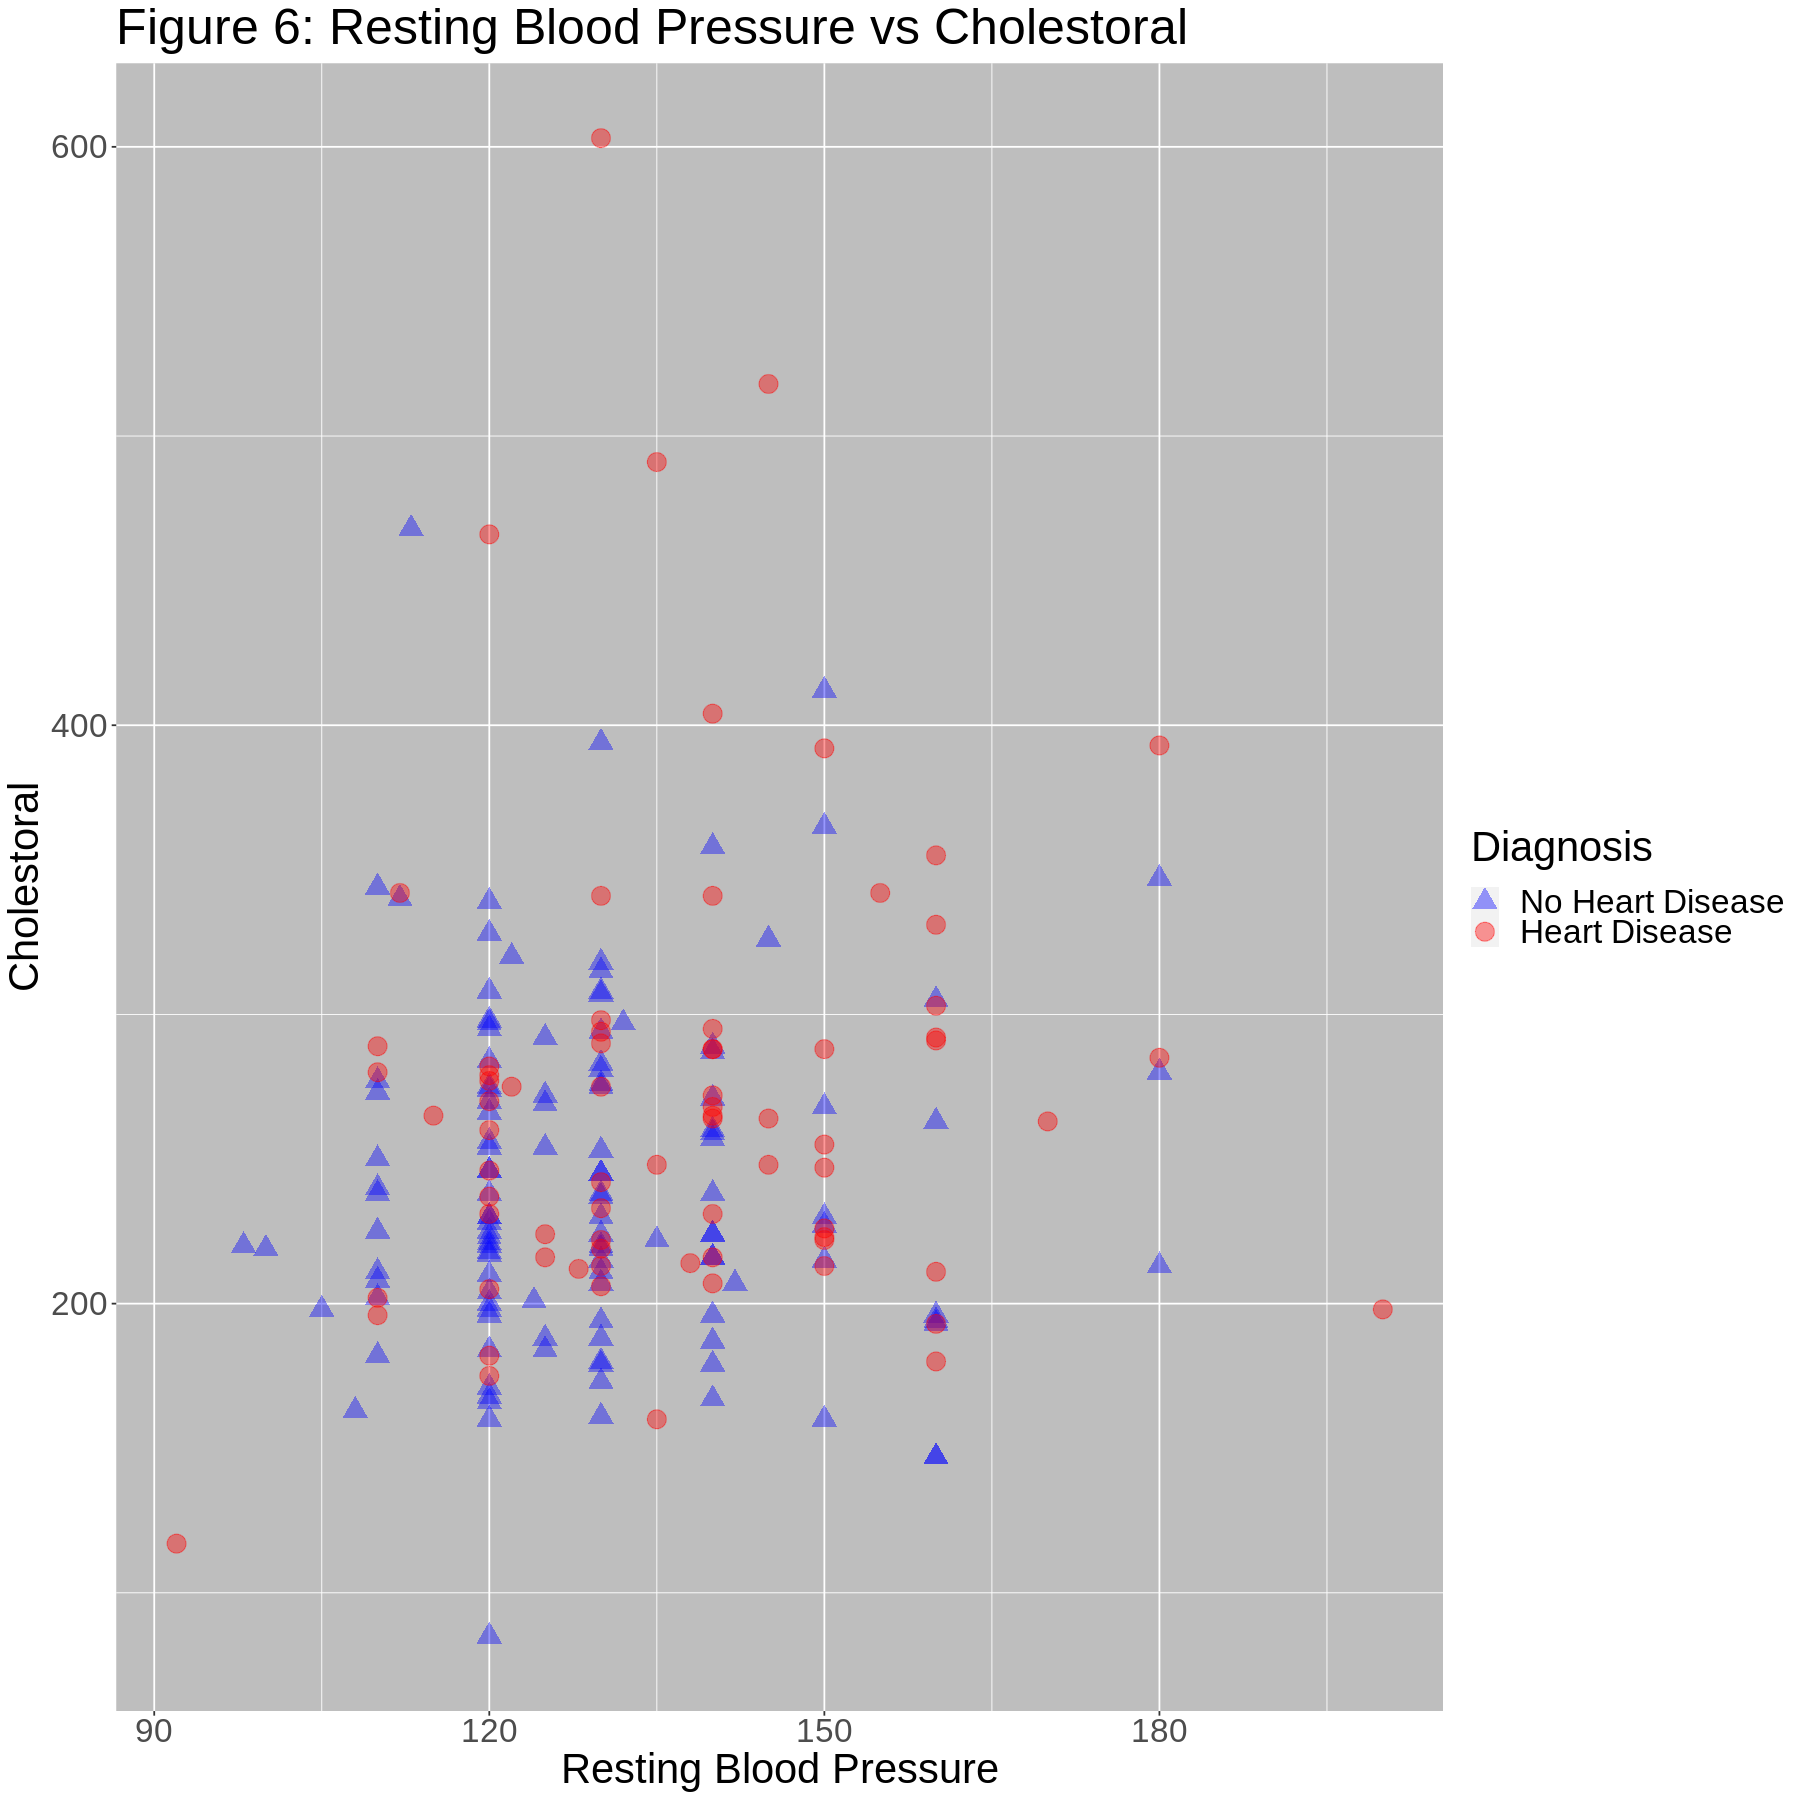

In [12]:
options(repr.plot.width = 15, repr.plot.height = 15)
cholestoral_vs_resting_blood_pressure_plot <- training_heart_data |>
    ggplot(aes(x = as.numeric(resting_blood_pressure), y = as.numeric(serum_cholestoral), color = as.factor(diagnosis), shape = as.factor(diagnosis))) +
    geom_point(alpha = 0.4, size = 5) +
    labs(x = "Resting Blood Pressure", y = "Cholestoral", color = "Diagnosis", shape = "Diagnosis") +
    theme(text = element_text(size = 25), panel.background = element_rect(fill = "grey")) +
    scale_color_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("blue", "red")) +
    scale_shape_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("triangle", "circle")) +
    ggtitle("Figure 6: Resting Blood Pressure vs Cholestoral")
cholestoral_vs_resting_blood_pressure_plot


Figure 6 shows there is no correlation between cholesterol and resting blood pressure in relation to diagnosis.

**METHODS**

After examining the scatterplots showing the relationships between the potential numeric predictor variables and the response variable, we conclude that our classifier will be based on the following predictors: age and maximum heart rate. This is because both age and maximum heart rate together show a correlation to heart disease diagnosis. For example, figures 1, 3, and 5 show older patients are more often diagnosed with heart disease while figures 2, 3, and 4 show patients with lower maximum heart rate are more often diagnosed. These are both good predictors of heart disease because older people tend to have lower maximum heart rate which increases the risk of heart disease (Harvard Health, 2020).  

**KNN MODEL**

Now that we have chosen age and maximum heart rate as the predictor variables for the classification model, we select these variables from the training and testing data. 

In [13]:
set.seed(1234) 

heart_train <- training_heart_data |> 
    mutate(age = as.numeric(age), max_heart_rate = as.numeric(max_heart_rate))|>
    select(age, max_heart_rate, diagnosis)
head(heart_train)

heart_test <- testing_heart_data |>
    mutate(age = as.numeric(age), max_heart_rate = as.numeric(max_heart_rate))|>
    select(age, max_heart_rate, diagnosis)
head(heart_test)

age,max_heart_rate,diagnosis
<dbl>,<dbl>,<fct>
31,150,0
32,165,0
32,184,0
32,155,0
33,185,0
34,190,0


age,max_heart_rate,diagnosis
<dbl>,<dbl>,<fct>
28,185,0
29,160,0
30,170,0
34,168,0
35,168,0
36,178,0


**Table 6:** Training and testing data

We first create a recipe that centers and scales the training data. This ensures that each predictor variable contributes equally to the model classifications by giving the observations a standard deviation of 1 and a mean of 0. We chose not to include upsampling to balance the ratio of observations because our preliminary analysis shows in table 4 that 62% of the observations do not have heart disease (value 0) compared to 37% that have heart disease (value 0) which is relatively balanced and will not significantly impact the model.  

In [14]:
heart_recipe <- recipe(diagnosis ~ age + max_heart_rate, data = heart_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
heart_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

Then, we create a knn model specification where the engine is set to "kknn" and the mode is set to "classification". We use tune() in the neighbours argument to tune the model to choose the best K value. The weight_func argument is set to "rectangular" so that each neighbour has 1 vote in the majority vote. 

In [15]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Now, we tune the model to choose the optimal number of neighbours to maximize accuracy. We do this by performing 5 fold cross validation for a range of k values. We chose 5 splits because choosing more splits increases the computation time. We create a 5 fold cross validation object that splits the training data into 5 equal splits. 

In [16]:
vfold <- vfold_cv(heart_train, v = 5, strata = diagnosis)

Next, we combine the recipe and model specification into a workflow that tests a range of K values using 5 fold cross validation. The kvals object specifis the range of K values to choose. We incorporate collect_metrics() so that we can view the accuracies of each K value to compare them. The collect_metrics() function contains irrelevant information so we filter for "accuracy". We now have a dataframe that contains the accuracy of the model performance for each K value using cross validation.

In [17]:
kvals <- tibble(neighbors = seq(from = 1, to = 80, by = 10))

knn_results <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_tune) |> 
    tune_grid(resamples = vfold, grid = kvals) |> 
    collect_metrics()|>
    filter(.metric == "accuracy")
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5723171,5,0.01705094,Preprocessor1_Model1
11,accuracy,binary,0.6810976,5,0.02984692,Preprocessor1_Model2
21,accuracy,binary,0.6568293,5,0.01122084,Preprocessor1_Model3
31,accuracy,binary,0.6768293,5,0.01440883,Preprocessor1_Model4
41,accuracy,binary,0.6517073,5,0.01590330,Preprocessor1_Model5
51,accuracy,binary,0.6615854,5,0.01547267,Preprocessor1_Model6
61,accuracy,binary,0.6764634,5,0.01441993,Preprocessor1_Model7
71,accuracy,binary,0.6567073,5,0.01453089,Preprocessor1_Model8


**Table 7:** Accuracy at different K values

Then we plot each K value against its accuracy so we can choose the most accurate K value for our model. 

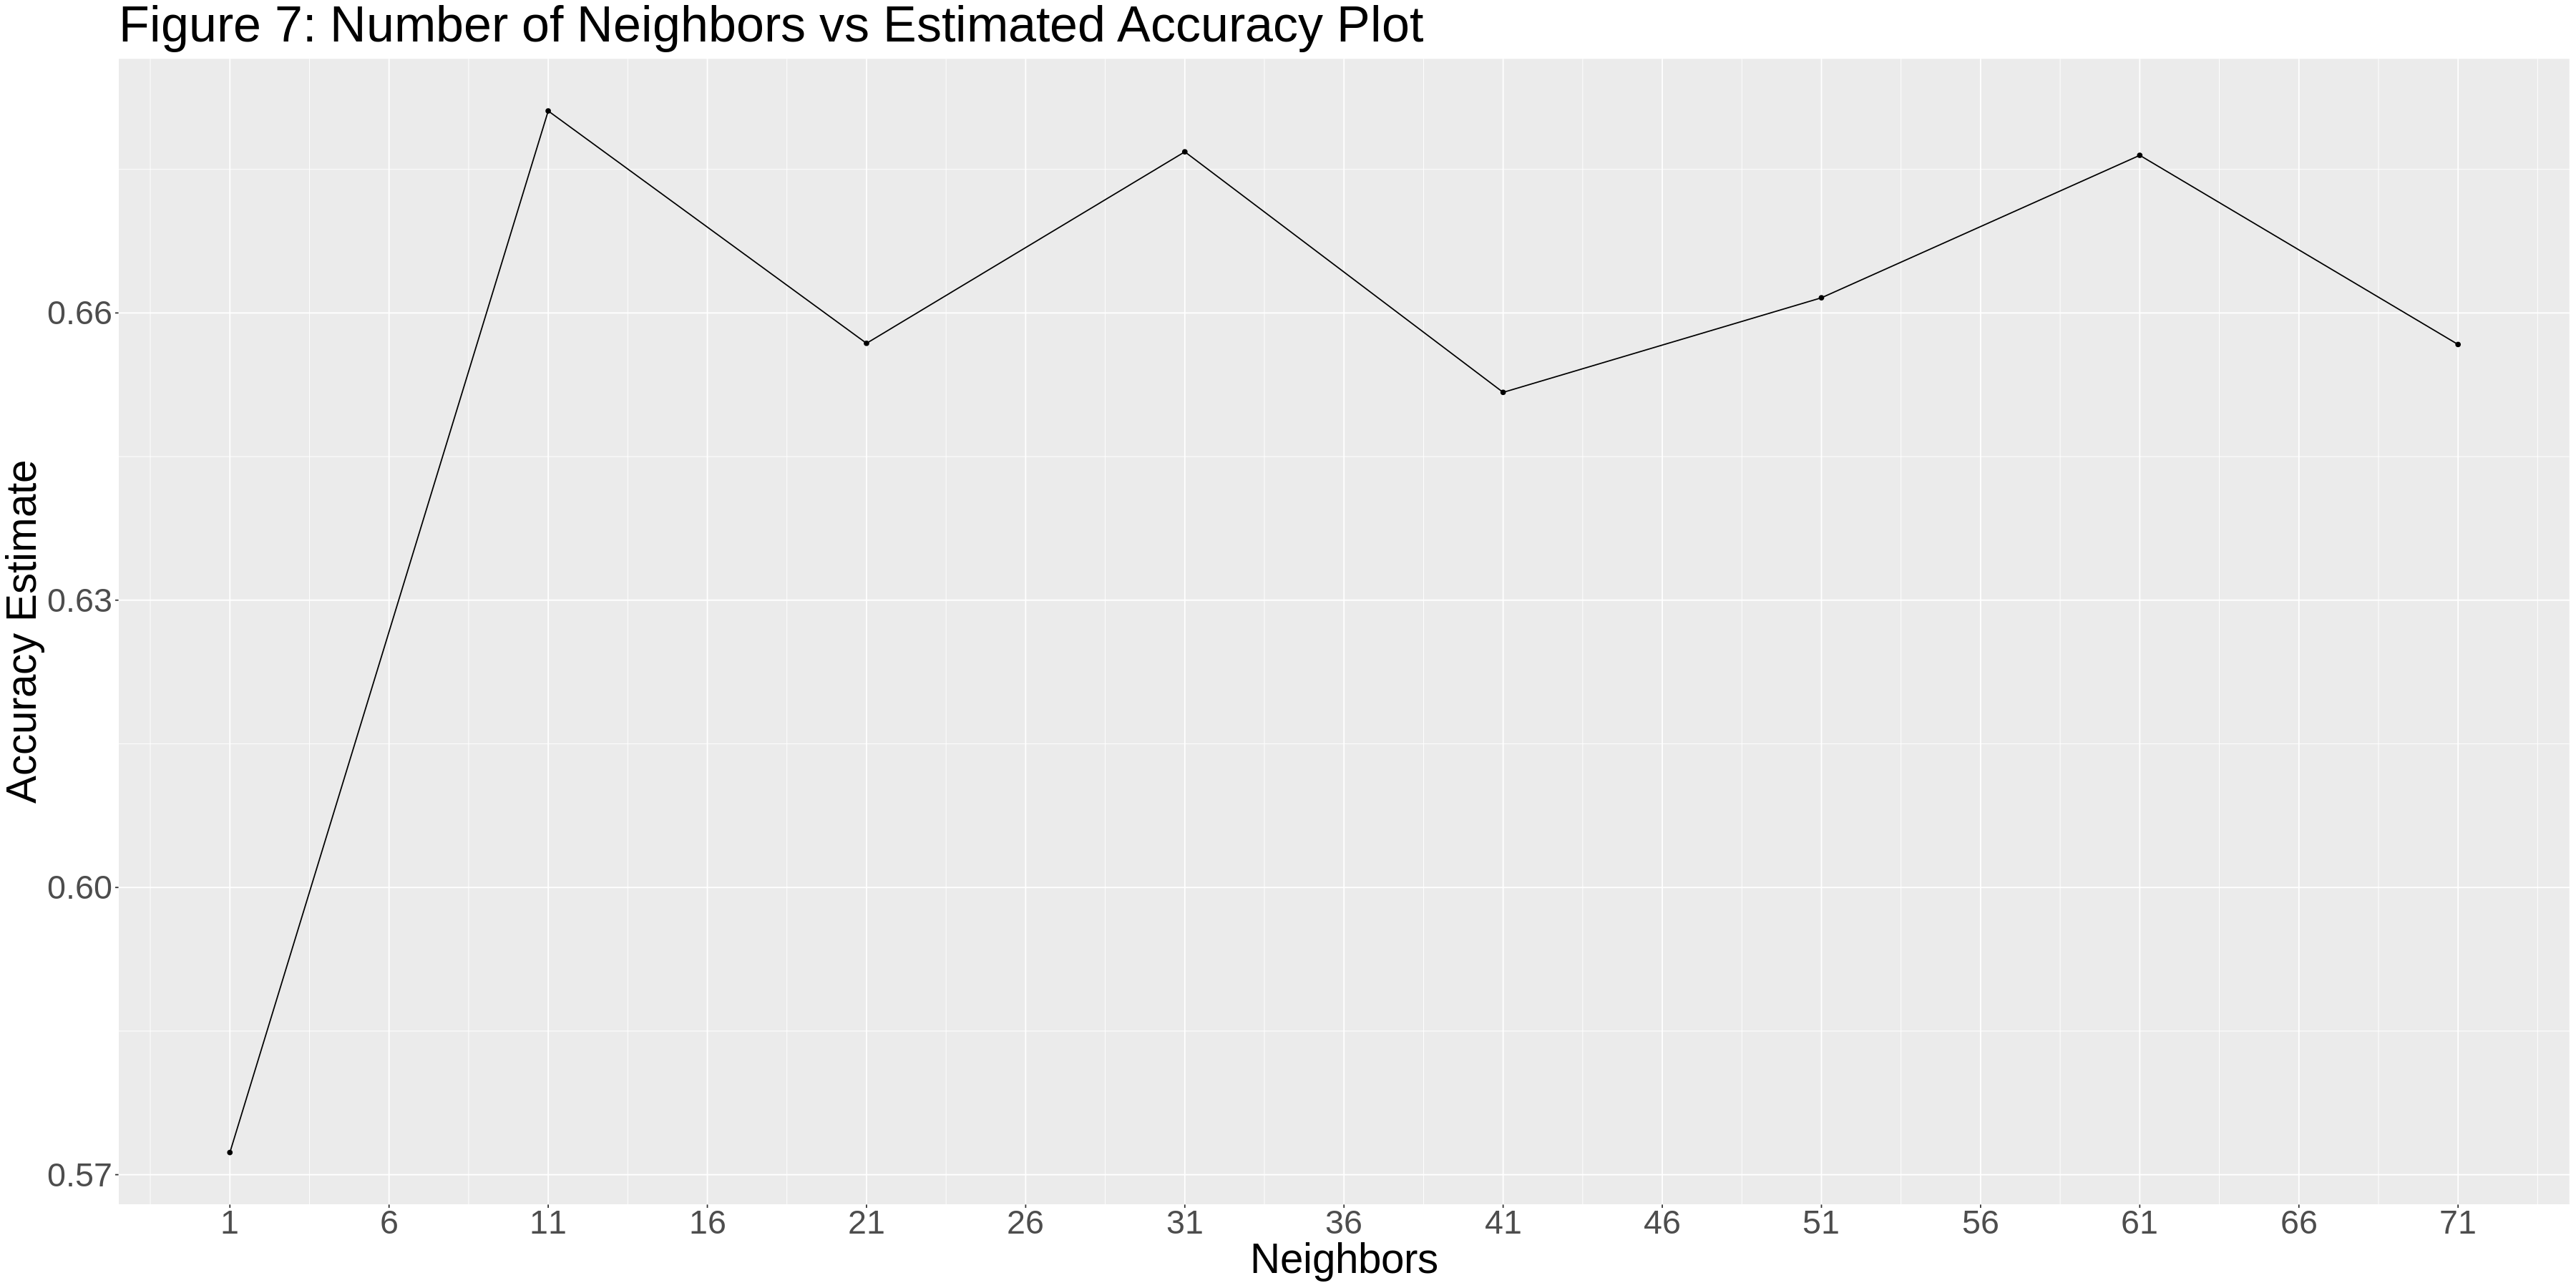

In [18]:
options(repr.plot.width = 30, repr.plot.height = 15)

accuracy_vs_k <- ggplot(knn_results, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    ggtitle("Figure 7: Number of Neighbors vs Estimated Accuracy Plot") +
    scale_x_continuous(breaks = seq(from = 1, to = 80, by = 5)) +
    theme(text = element_text(size = 35))
accuracy_vs_k

According to figure 7, k=11 reports the highest accuracy (68.11%). Hence, we choose 11 neighbours for our model because this provides the most accurate predictions.

Now we create a new model specification with our selected k value that we saved to an object. We use the same recipe created above and add it into a workflow, fitting it to the training data. 

In [19]:
k <- 11

knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = k) |>
    set_engine("kknn") |>
    set_mode("classification")
knn_spec_2

knn_fit <- workflow() |> 
    add_recipe(heart_recipe) |> 
    add_model(knn_spec_2) |> 
    fit(data = heart_train)
knn_fit

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = k
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(11,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3383085
Best kernel: rectangular
Best k: 11

We now evaluate the model's accuracy by having it predict on the testing data. After filtering for accuracy, we create a confusion matrix that shows the number of incorrect and correct predictions based on the true diagnosis. 

In [20]:
heart_test_preds <- predict(knn_fit, heart_test) |>
    bind_cols(heart_test)
glimpse(heart_test_preds)

heart_preds_accuracy <- heart_test_preds |>
    metrics(truth = diagnosis, estimate = .pred_class) |>
    filter(.metric == "accuracy")
heart_preds_accuracy

Rows: 69
Columns: 4
$ .pred_class    <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ age            <dbl> 28, 29, 30, 34, 35, 36, 37, 38, 38, 39, 41, 41, 42, 43,…
$ max_heart_rate <dbl> 185, 160, 170, 168, 168, 178, 130, 150, 130, 106, 160, …
$ diagnosis      <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6086957


**Table 8:** Accuracy of the model on the testing data

Table 8 shows our model predicted the class of the testing data with an accuracy of 60.87%. 

In [21]:
confusion_matrix <- heart_test_preds |>
    conf_mat(truth = diagnosis, estimate = .pred_class)
confusion_matrix

          Truth
Prediction  0  1
         0 33 17
         1 10  9

**Table 9:** Confusion matrix of the predictions on the testing data

This confusion matrix tells us the model correctly predicted the true class of 42 observations and incorrectly predicted 27 observations in the testing data. 33 observations were correctly predicted to not have heart disease and 9 observations were correctly predicted to have heart disease. There were 17 observations with heart disease incorrectly predicted to not have it (false negative) and 10 observations that did not have heart disease that were incorrectly predicted to have it (false positive). This is a large number of errors, especially when the presence of heart disease is missed. Our model tends towards predicting no heart disease, meaning it will fail to diagnose more patients that have heart disease than it will wrongly diagnose heart disease. 

We now create a bar graph that visualizes the confusion matrix from table 9 in a more readable format. 

In [22]:
conf_table <- heart_test_preds|>
    select(.pred_class, diagnosis)|>
    group_by(.pred_class, diagnosis)|>
    summarize(count = n())

renamed_conf_table <- conf_table |>
    mutate(heart_diagnosis = str_replace(diagnosis, "0", "No Heart Disease")) |>
    mutate(heart_diagnosis = str_replace(heart_diagnosis, "1", "Heart Disease"))

`summarise()` has grouped output by '.pred_class'. You can override using the
`.groups` argument.


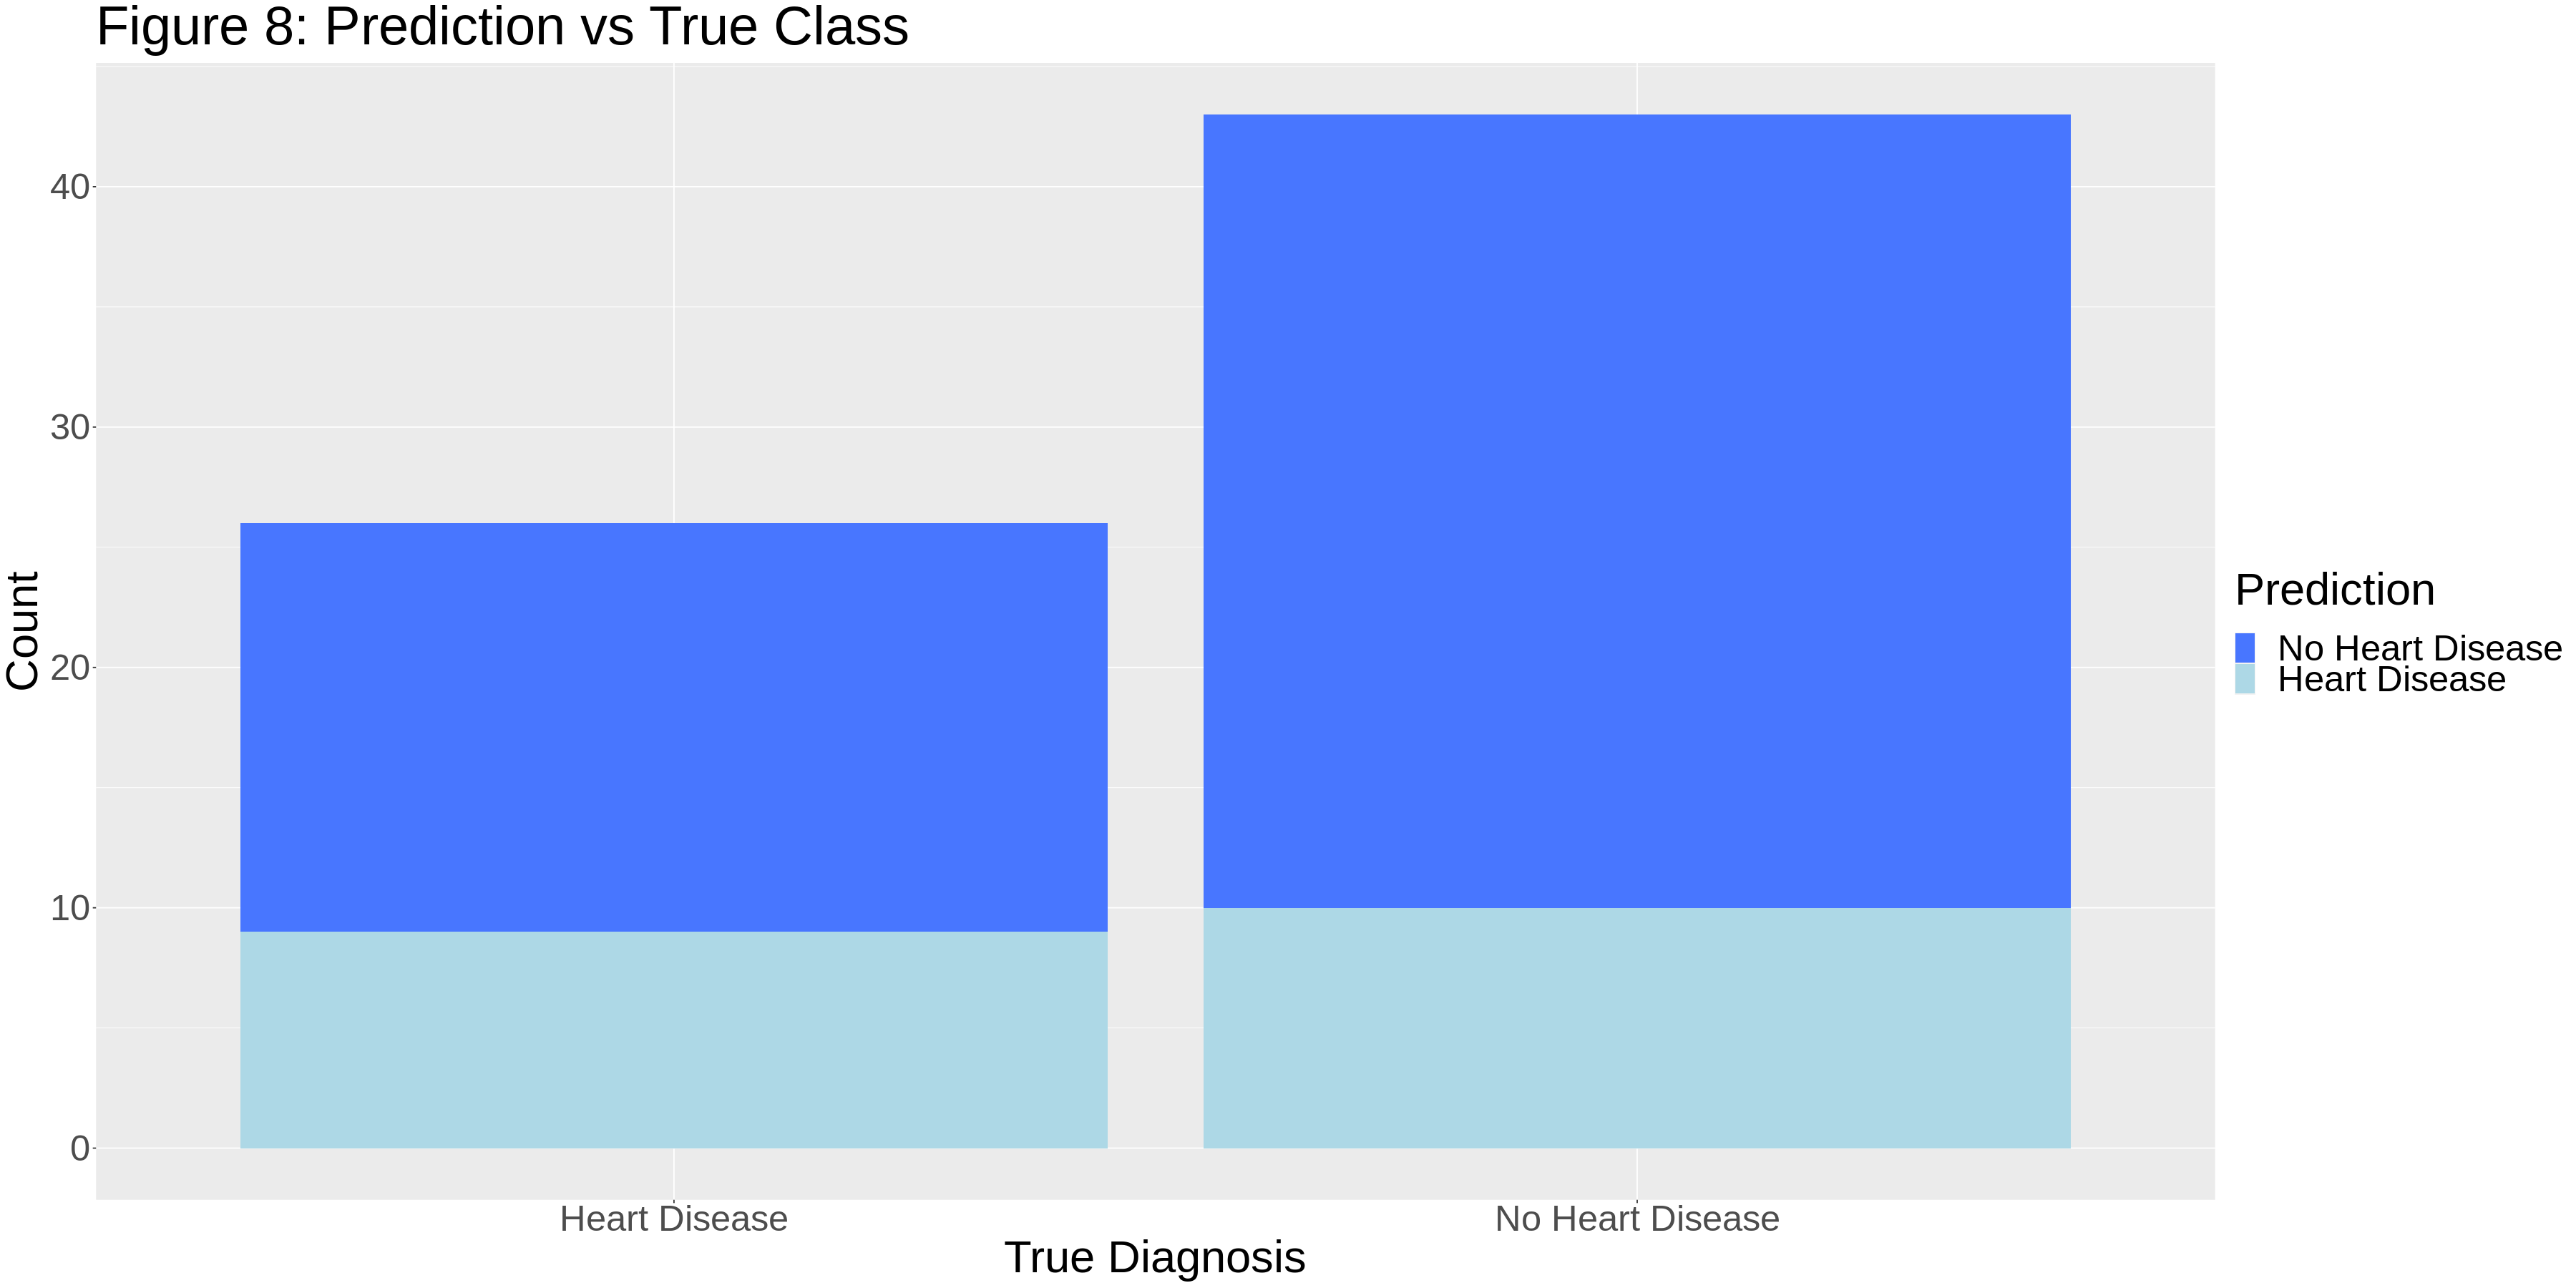

In [23]:
conf_plot <- renamed_conf_table|>
    ggplot(aes(x = heart_diagnosis, y = count, fill = .pred_class))+
    geom_bar(stat = "identity")+
    labs(x = "True Diagnosis", y = "Count", fill = "Prediction")+
    ggtitle("Figure 8: Prediction vs True Class")+
    scale_fill_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("royalblue1", "lightblue")) +
    theme(text = element_text(size = 38))
conf_plot

Figure 8 shows the same information as table 9. The bar on the right shows observations in the testing data with true class of no heart disease and the bar on the left shows observations with true class of heart disease. This means the model is better at predicting on new observations that do not have heart disease than predicting on new observations that have heart disease. In a clinical setting, this is significantly worse because it is more dangerous to incorrectly predict a patient has no heart disease when they really do have it. 


**OUTCOMES AND SIGNIFICANCE** 

In conclusion, our model's accuracy is 60.87% when predicting on the testing data with a tendency to predict no diagnosis as seen in table 9 and figure 8. We can compare this to the majority classifier, which always predicts the majority class, to assess its performance. In regards to our training data, the majority classifier would have an accuracy of 62.69% because the majority of observations in the training data do not have heart disease as seen in table 4. Our model has a lower accuracy than the majority classifier. This means a model that predicts no heart disease for every new observation would be more accurate to the true class than the model we trained using the selected predictors. There are several potential reasons why our model's accuracy is lower. Firstly, the dataset is relatively small so there are not many observations on which to train and predict an accurate model. Secondly, the correlation between the predictor variables in relation to the diagnosis was weak, as shown in figure 3, which could have made the majority vote in the knn classification less accurate to an observation's true class. It was not necessarily clear whether age or lower maximum heart rate indicated a higher risk of heart disease because the datapoints were relatively evenly distributed by diagnosis. Thirdly, choosing 11 neighbours when there were only 201 observations in the training data could have caused slight underfitting. This occurs when too many of the training observations help to determine the class of the new observations, resulting in an averaging effect where the model isn't influenced enough by the training data. This may have been why it did not predict well on our testing data.

We expected that our classification model would accurately predict whether individuals have heart disease based on its relationship to age and maximum heart rate, as shown in figures 1-6. However, according to table 9, the model made 17 false negatives and 10 false positives. Both of which can have adverse effects when applied to health care. If a new patient is incorrectly diagnosed to have heart disease by the model, it could cause the patient to worry and be given medication unnecessarily. Similarly, if a new patient is incorrectly diagnosed to not have heart disease, they may not recieve proper medical attention and it could result in death. If the model could correctly predict the presence of heart disease with high accuracy, it would provide faster diagnoses for people with risk factors for heart disease. By predicting the presence of heart disease earlier, this could improve healthcare through early administration of treatments. With further improvement, this model could be used to accurately diagnose the presence of heart disease. 

To improve our model, we could use the kmeans clustering algorithm to better determine the relationship between predictor variables and diagnosis, which may have not been clear from figures 1-6. Another improvement could be using 10-fold cross validation instead of 5-fold to get a better estimate of the accuracies to choose a more optimal K value, though this could increase computation time and require a faster computer. We could also change the split to have more data in the testing set so that we can better estimate its performance, or get new observations to test on so that the entire dataset can be used to train the model. 

Further data analysis questions include whether other variables besides those in the Hungarian data set contribute to heart disease and could improve our model's accuracy. We could also question whether incorporating data from other countries into our model would increase the size of the training data and increase its accuracy. Lastly, we could question how this algorithm could be used clinically to diagnose heart disease. 

**REFERENCES**

Centers for Disease Control and Prevention. (2022, July 12). About heart disease. Centers for Disease Control and Prevention. Retrieved March 10, 2023, from https://www.cdc.gov/heartdisease/about.htm 

UCI Machine Learning Repository: Heart disease data set. (n.d.). Retrieved March 10, 2023, from https://archive.ics.uci.edu/ml/datasets/Heart+Disease 

WebMD. (n.d.). High cholesterol and high blood pressure. WebMD. Retrieved March 10, 2023, from https://www.webmd.com/cholesterol-management/high-cholesterol-and-high-blood-pressure

What your heart rate is telling you. Harvard Health. (2020, August 30). Retrieved March 11, 2023, from https://www.health.harvard.edu/heart-health/what-your-heart-rate-is-telling-you

World Health Organization. (n.d.). Cardiovascular diseases. World Health Organization. Retrieved March 10, 2023, from https://www.who.int/health-topics/cardiovascular-diseases/ 